## Day 25 Lecture 1 Assignment

In this assignment, we will evaluate the performance of the model we built yesterday on the Chicago traffic crash data. We will also perform hyperparameter tuning and evaluate a final model using additional metrics (e.g. AUC-ROC, precision, recall, etc.)

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ds_useful

Since we will be building on the model we built in the last assignment, we will need to redo all of the data preparation steps up to the point of model building. These steps include creating the response, missing value imputation, and one-hot encoding our selected categorical variables. The quickest way to get going would be to open last week's assignment, make a copy, and build on it from there.

In [21]:
# Load the dataset
crash_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')

#Rename the columns for easy reference
crash_data.rename(columns=lambda x: x.lower(), inplace=True)

# create a binary response column by modifying the "DAMAGE" column. Consider "OVER \$1500" to be the positive class, and under \$1500 to be the negative class.
crash_data.damage = np.where(crash_data.damage == 'OVER $1,500', 1, 0)

# Dropping all columns with more than 5% missing data
    # Get missing data
missing = ds_useful.missingness_summary(crash_data)
    # Drop the indexes of missing whose values are greater than 5
crash_data.drop(columns=missing.loc[missing > 5].index, axis=1, inplace=True)

# Imputate all numeric (implied) data with the linear model
crash_data = crash_data.interpolate(method='linear')

# Drop any null categorical values
for col in crash_data.select_dtypes('object').columns:
    crash_data.drop(crash_data.loc[crash_data[col].isnull()].index, axis='rows', inplace=True)

# Define raw feature variables from attributes
keep = ['posted_speed_limit', 'weather_condition', 'injuries_total', 'first_crash_type', 'damage']
keep_df = crash_data[keep]

# Identify the highest occuring variable for each. We'll drop these to help dimensionality.
keep_df.drop(keep_df.loc[keep_df['weather_condition'] == 'CLEAR'].index, inplace=True)
keep_df.drop(keep_df.loc[keep_df['first_crash_type'] == 'REAR END'].index, inplace=True)

# Now let's one hot encode the categorical data.
feature_df = pd.get_dummies(keep_df.select_dtypes('object'), drop_first=True)

# Then we'll add our categorical data to the feature dataframe
feature_df['posted_speed_limit'] = keep_df['posted_speed_limit']
feature_df['injuries_total'] = keep_df['injuries_total']

# Finally, we'll identify our target label and create X and y groups
target = 'damage'
X = feature_df
Y = keep_df[target]

print('target:\n', target)
print('\n\nfeatures:')
X.columns

target:
 damage


features:


Index(['weather_condition_CLOUDY/OVERCAST', 'weather_condition_FOG/SMOKE/HAZE',
       'weather_condition_FREEZING RAIN/DRIZZLE', 'weather_condition_OTHER',
       'weather_condition_RAIN', 'weather_condition_SEVERE CROSS WIND GATE',
       'weather_condition_SLEET/HAIL', 'weather_condition_SNOW',
       'weather_condition_UNKNOWN', 'first_crash_type_ANIMAL',
       'first_crash_type_FIXED OBJECT', 'first_crash_type_HEAD ON',
       'first_crash_type_OTHER NONCOLLISION', 'first_crash_type_OTHER OBJECT',
       'first_crash_type_OVERTURNED', 'first_crash_type_PARKED MOTOR VEHICLE',
       'first_crash_type_PEDALCYCLIST', 'first_crash_type_PEDESTRIAN',
       'first_crash_type_REAR TO FRONT', 'first_crash_type_REAR TO REAR',
       'first_crash_type_REAR TO SIDE',
       'first_crash_type_SIDESWIPE OPPOSITE DIRECTION',
       'first_crash_type_SIDESWIPE SAME DIRECTION', 'first_crash_type_TRAIN',
       'first_crash_type_TURNING', 'posted_speed_limit', 'injuries_total'],
      dtype='obje

Statsmodels' implementation of logistic has certain advantages over scikit-learn's, such as clean, easy to read model summary output and statistical inference values (e.g. p-values). However, scikit-learn is preferable for model evaluation, so we will switch to the scikit-learn implementation for this exercise. 

Run logistic regression on the training set and use the resulting model to make predictions on the test set. Calculate the train and test error using logarithmic loss. How do they compare to each other?

In [24]:
# answer goes here
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Create Training and Testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

# Initiate the lr object, using the .1 C-value, determined from the other assignment
lr = LogisticRegression(C=.1, penalty='l2', solver='lbfgs', random_state=1)
# Train it with the training data
lr.fit(X_train, Y_train)

# Make probabalistic predictions on the test and train sets
train_prob_pred = lr.predict_proba(X_train)
test_prob_pred = lr.predict_proba(X_test)

print('Training Set Score', lr.score(X_train, Y_train))
print('Test Set Score    ', lr.score(X_test, Y_test))

# Use proba predictions to calculate the log loss
train_loss = log_loss(Y_train, train_prob_pred)
test_loss = log_loss(Y_test, test_prob_pred)

print('Training Set Error', train_loss)
print('Test Set Error    ', test_loss)

print('\nThe error for the test set is slightly larger than the error for the training set. This leads me to believe that there may be a slight amount of overfitting. However, in a previous assignment, I actually optimized this log_loss error to choose hyperparameters, so this is about as good as this will get.')

Training Set Score 0.6246670809659091
Test Set Score     0.6247669773635153
Training Set Error 0.6388141672799862
Test Set Error     0.6429140912598977

The error for the test set is slightly larger than the error for the training set. This leads me to believe that there may be a slight amount of overfitting. However, in a previous assignment, I actually optimized this log_loss error to choose hyperparameters, so this is about as good as this will get.


Next, evaluate the performance of the same model using 10-fold CV. Use the training data and labels, and print out the mean log loss for each of the 10 CV folds, as well as the overall CV-estimated test error. How do the estimates from the individual folds compare to the result from our previous single holdout set? How much variability in the estimated test error do you see across the 10 folds?

Note: scikit-learn's *cross_val_score* function provides a simple, one-line method for doing this. However, be careful - the default score returned by this function may not be log loss!

In [25]:
# answer goes here
from sklearn.model_selection import cross_validate, cross_val_score
cv_scores = cross_val_score(lr, X_train, Y_train, cv=10)
print('Accuracy for the 10 folds:', cv_scores)
print('Mean accuracy from folds:', np.mean(cv_scores))

Accuracy for the 10 folds: [0.6298269  0.62827341 0.62494452 0.62472259 0.62072792 0.626498
 0.61775805 0.62552719 0.61931188 0.62130966]
Mean accuracy from folds: 0.623890011246566


Scikit-learn's logistic regression function has a built-in regularization parameter, C (the larger the value of C, the smaller the degree of regularization). Use cross-validation and grid search to find an optimal value for the parameter C.

In [27]:
# answer goes here
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(lr, {'C': [0.01, 1, 2, 4, 8]}, cv=10, scoring='neg_log_loss')
clf.fit(X_train, Y_train)

clf.cv_results_

{'mean_fit_time': array([0.67830498, 0.71819649, 0.83272674, 0.88566787, 0.89651463]),
 'std_fit_time': array([0.08005012, 0.09011184, 0.15138331, 0.26665337, 0.34801581]),
 'mean_score_time': array([0.00693216, 0.00742834, 0.0067807 , 0.00988274, 0.00907457]),
 'std_score_time': array([0.00234433, 0.00332471, 0.00159596, 0.00724691, 0.00440664]),
 'param_C': masked_array(data=[0.01, 1, 2, 4, 8],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01}, {'C': 1}, {'C': 2}, {'C': 4}, {'C': 8}],
 'split0_test_score': array([-0.64558237, -0.64111695, -0.63998135, -0.64078858, -0.6408459 ]),
 'split1_test_score': array([-0.638566  , -0.63197943, -0.63192819, -0.63214968, -0.63148387]),
 'split2_test_score': array([-0.64556932, -0.64157368, -0.64115866, -0.64113523, -0.64046487]),
 'split3_test_score': array([-0.64277355, -0.63789102, -0.63781067, -0.63787057, -0.63795176]),
 'split4_test_score': array([-0.64590513, 

Re-train a logistic regression model using the best value of C identified by 10-fold CV on the training data and labels. Afterwards, do the following:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Note: the performance of our simple logistic regression model with just four features will not be very good, but this is not entirely unexpected. There are many other features that can be incorporated into the model to improve its performance; feel free to experiment!

In [35]:
# answer goes here

lr_model = LogisticRegression(penalty='l2', solver='lbfgs', C=2)
lr_model.fit(X_train, Y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

new_lr_pred = lr_model.predict(X_test)

new_lr_report = classification_report(Y_test, new_lr_pred)
print(new_lr_report)

precision    recall  f1-score   support

           0       0.64      0.13      0.22      4494
           1       0.62      0.95      0.75      6771

    accuracy                           0.62     11265
   macro avg       0.63      0.54      0.49     11265
weighted avg       0.63      0.62      0.54     11265



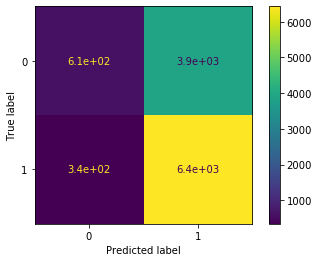

In [37]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Plot confusion matrix

plot_confusion_matrix(lr_model, X_test, Y_test)

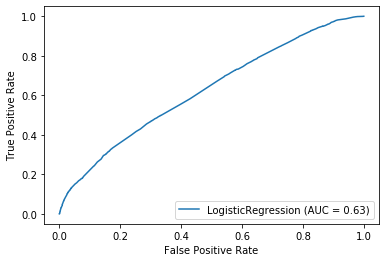

In [39]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(lr_model, X_test, Y_test)

# Doneso 